In [1]:
import requests

In [2]:
from bs4 import BeautifulSoup

In [3]:
import time

In [4]:
import re

In [5]:
# Define URLs for each city to be scraped
city_urls = {
    "Hyderabad": "https://www.magicbricks.com/property-for-rent/residential-real-estate?cityName=Hyderabad",
    "Bangalore": "https://www.magicbricks.com/property-for-rent/residential-real-estate?cityName=Bangalore",
    "Mumbai": "https://www.magicbricks.com/property-for-rent/residential-real-estate?cityName=Mumbai",
    "Pune": "https://www.magicbricks.com/property-for-rent/residential-real-estate?cityName=Pune",
    "Chennai": "https://www.magicbricks.com/property-for-rent/residential-real-estate?cityName=Chennai"
}

# Define headers to prevent a browser from blocking
headers = {'User-Agent': 'Mozilla/5.0'}

max_properties_per_city = 200

# list to store all scraped data
all_data = []

# Keywords to detect actual property types from title text
property_keywords = ['Apartment', 'Flat', 'Studio', 'Villa', 'House', 'Floor', 'Penthouse', 'Row House', 'Farm']

# Loop through each city and its corresponding URL
for city, base_url in city_urls.items():
    print(f"\nScraping {city}...")
    city_data = []   # Store city-specific listings
    page = 1      # Start from page 1

    # Loop through pages until desired property count is reached
    while len(city_data) < max_properties_per_city:
        url = f"{base_url}&page={page}"
        res = requests.get(url, headers=headers)
        soup = BeautifulSoup(res.text, 'html.parser')

        # Find all property listing cards on the page
        listings = soup.find_all("div", class_="mb-srp__card")
        if not listings:
            print(" No listings found, stopping.")
            break

        # Loop through each property card
        for listing in listings:
            try:
                # Extract bhk from title
                title_tag = listing.find("h2", class_="mb-srp__card--title")
                title = title_tag.get_text(strip=True)

                bhk_match = re.search(r"(\d+)\s*BHK", title.upper())
                bhk = bhk_match.group(1) if bhk_match else None

                # Extract location
                locality = title.split("in", 1)[-1].strip() if "in" in title else None

                # Detect property type from title
                title_clean = title.replace(",", " ").replace("-", " ")
                title_words = title_clean.split()
                prop_type_from_title = next((word for word in title_words if word.capitalize() in property_keywords), None)
            except:
                bhk = locality = prop_type_from_title = None

            # Extract rent price
            try:
                rent = listing.find("div", class_="mb-srp__card__price--amount").get_text(strip=True)
                rent = rent.replace("₹", "").replace(",", "").strip()
            except:
                rent = None

            summary = listing.find("div", class_="mb-srp__card__summary__list")
            summary_items = summary.find_all("div", class_="mb-srp__card__summary__list--item") if summary else []

            # Initializing Variables
            area = furnishing = facing = property_type = None
            
            # Loop through summary items and extract specific features
            for item in summary_items:
                try:
                    label = item.find("div", class_="mb-srp__card__summary--label").get_text(strip=True).lower()
                    value = item.find("div", class_="mb-srp__card__summary--value").get_text(strip=True)

                    if "area" in label:
                        area = value
                    elif "furnish" in label:
                        furnishing = value
                    elif "facing" in label:
                        facing = value
                    elif "property type" in label or "type" in label:
                        property_type = value
                except:
                    continue

            # Final fallback if property_type is missing or invalid
            if not property_type or property_type.lower() in ["for", "in", "rent", "sale"]:
                property_type = prop_type_from_title

            if not bhk or not locality:
                continue

            city_data.append({
                "City": city,
                "BHK": bhk.strip(),
                "Location": locality.strip(),
                "Price (₹)": rent,
                "Area (sqft)": area.strip() if area else None,
                "Property Type": property_type.strip() if property_type else None,
                "Furnishing": furnishing.strip() if furnishing else None,
                "Property Facing": facing.strip() if facing else None
            })

            if len(city_data) >= max_properties_per_city:
                break

        page += 1    # Move to next Page
        time.sleep(1)  # delay to avoid overloading the server


    # Append city data to the master list
    all_data.extend(city_data)
print("\nScraping completed...")


Scraping Hyderabad...

Scraping Bangalore...

Scraping Mumbai...

Scraping Pune...

Scraping Chennai...

Scraping completed...


In [6]:
import pandas as pd

In [7]:
# Save to CSV
df = pd.DataFrame(all_data)
df.to_csv("MagicBricksProject_Scraped_Data.csv", index=False)
print("\nData saved to MagicBricksProject_Scraped_Data.csv")


Data saved to MagicBricksProject_Scraped_Data.csv


In [8]:
# prints number of columns
print("Number of columns:",df.shape[1])

Number of columns: 8


In [9]:
# prints number of rows
print("Number of rows:",df.shape[0])

Number of rows: 1000


In [10]:
# Print the data types of each column
print("Data types of each column:\n",df.dtypes)

Data types of each column:
 City               object
BHK                object
Location           object
Price (₹)          object
Area (sqft)        object
Property Type      object
Furnishing         object
Property Facing    object
dtype: object


In [11]:
# Print the number of missing values in each column
print("Missing values in each column:\n",df.isnull().sum())

Missing values in each column:
 City                 0
BHK                  0
Location             0
Price (₹)            0
Area (sqft)          0
Property Type        0
Furnishing           1
Property Facing    125
dtype: int64


In [12]:
# It shows the duplicated rows count
num_duplicates = df.duplicated().sum()
print(f"Total duplicate rows (all columns): {num_duplicates}")

Total duplicate rows (all columns): 3


In [13]:
# # Drop duplicate rows based on the all columns to ensure unique listings
df.drop_duplicates(subset=['City', 'BHK', 'Location', 'Price (₹)', 'Area (sqft)', 'Property Type', 'Furnishing', 'Property Facing'], inplace=True)

In [14]:
num_duplicates = df.duplicated().sum()
print(f"Total duplicate rows (all columns): {num_duplicates}")

Total duplicate rows (all columns): 0


In [15]:
print("Number of rows:",df.shape[0])

Number of rows: 997


##### Data Cleaning

In [16]:
# List of locations 
localities = [
    "Kondapur", "Narsingi", "Gachibowli", "Tellapur", "Kompally", "Kollur", "Shamshabad","Nalagandla",
    "Bachupally", "Miyapur", "Hitech City", "Puppalaguda", "Kokapet", "Manikonda", "Madhapur",
    "Whitefield", "Varthur", "Hebbal", "Yelahanka", "Devanahalli",
    "Sarjapur", "Electronic City", "Kanakapura Road", "Bannerghatta Main Road","Rajajinagar",
    "Mulund", "Andheri", "Chembur", "Worli", "Powai", "Borivali", "Bandra", "Wadala",
    "Goregaon", "Kandivali East", "Thakur Village", "Juhu", "Kandivali", "Hadapsar", "Mundhwa",
    "Kharadi", "Baner", "Hadapsar", "Hinjawadi", "Wagholi", "Wakad", "Balewadi",
    "NIBM Road", "Viman Nagar", "Undri", "Sholinganallur", "Medavakkam", "Pallikaranai", "Porur", "Perungudi", 
    "Pallavaram", "Guduvancheri", "Kelambakkam", "Thiruvanmiyur", "Padur"
]

# Lowercased for comparison
localities_lower = [loc.lower() for loc in localities]

# Function to clean location
def clean_location(text):
    if pd.isna(text):
        return ''
    text = re.sub(r'\s+', ' ', text).lower()
    for loc, loc_lower in zip(localities, localities_lower):
        if loc_lower in text:
            return loc
    return ''

# Update Location column in-place
df['Location'] = df['Location'].apply(clean_location)  

In [17]:
# renaming the column
df.rename(columns={"Price (₹)": "Price"}, inplace=True)

In [18]:
# Function to clean and convert price to integer
def clean_price(price):
    price = str(price).replace(',', '').strip().lower()

    if 'lac' in price:
        num = float(price.split()[0])
        return int(round(num * 100000))
    elif 'cr' in price:
        num = float(price.split()[0])
        return int(round(num * 10000000))
    else:
        return int(''.join(filter(str.isdigit, price)))
    
# Apply cleaning function to 'Price' column
df["Price"] = df["Price"].apply(clean_price)

In [19]:
# Extract numeric part from 'Area (sqft)' and convert to integer
df["Area (sqft)"] = df["Area (sqft)"].str.extract(r'(\d+)', expand=False).astype(float).astype(int)

In [20]:
df.head(10)

,City,BHK,Location,Price,Area (sqft),Property Type,Furnishing,Property Facing
0,Hyderabad,1,Kondapur,20100,450,Flat,Semi-Furnished,East
1,Hyderabad,3,Kondapur,69000,1880,Flat,Furnished,East
2,Hyderabad,3,Kokapet,65000,1769,Flat,Semi-Furnished,East
3,Hyderabad,4,Kokapet,230000,5100,Villa,Semi-Furnished,East
4,Hyderabad,3,Kokapet,55000,894,Flat,Semi-Furnished,East
5,Hyderabad,4,Kokapet,450000,7332,Flat,Unfurnished,None
6,Hyderabad,3,Kokapet,70000,1565,Flat,Semi-Furnished,East
7,Hyderabad,4,,75000,2800,Villa,Furnished,East
8,Hyderabad,3,Kokapet,60000,1957,Flat,Semi-Furnished,East
9,Hyderabad,4,Hitech City,290000,4070,Flat,Semi-Furnished,West


In [21]:
import numpy as np

In [22]:
# Replace empty strings in 'Location' with NaN
df['Location'] = df['Location'].replace('', np.nan)

In [23]:
# Fill missing 'Location' values with the most frequent location (mode) within each city
df['Location'] = df.groupby('City')['Location'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown')
)

In [24]:
# Count remaining missing values in 'Location' column
df['Location'].isna().sum()

0

In [25]:
# Fill missing 'Property Facing' values with the most frequent location (mode) within each city
df['Property Facing'] = df.groupby('Location')['Property Facing'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'East')
)

In [26]:
# Count remaining missing values in 'Location' column
df['Property Facing'].isna().sum()

0

In [27]:
df.head(10)

,City,BHK,Location,Price,Area (sqft),Property Type,Furnishing,Property Facing
0,Hyderabad,1,Kondapur,20100,450,Flat,Semi-Furnished,East
1,Hyderabad,3,Kondapur,69000,1880,Flat,Furnished,East
2,Hyderabad,3,Kokapet,65000,1769,Flat,Semi-Furnished,East
3,Hyderabad,4,Kokapet,230000,5100,Villa,Semi-Furnished,East
4,Hyderabad,3,Kokapet,55000,894,Flat,Semi-Furnished,East
5,Hyderabad,4,Kokapet,450000,7332,Flat,Unfurnished,East
6,Hyderabad,3,Kokapet,70000,1565,Flat,Semi-Furnished,East
7,Hyderabad,4,Kondapur,75000,2800,Villa,Furnished,East
8,Hyderabad,3,Kokapet,60000,1957,Flat,Semi-Furnished,East
9,Hyderabad,4,Hitech City,290000,4070,Flat,Semi-Furnished,West


In [28]:
num_duplicates = df.duplicated().sum()
print(f"Total duplicate rows (all columns): {num_duplicates}")

Total duplicate rows (all columns): 1


In [29]:
df.drop_duplicates(subset=['City', 'BHK', 'Location', 'Price', 'Area (sqft)', 'Property Type', 'Furnishing', 'Property Facing'], inplace=True)

In [30]:
num_duplicates = df.duplicated().sum()
print(f"Total duplicate rows (all columns): {num_duplicates}")

Total duplicate rows (all columns): 0


In [31]:
print("Missing values in each column:\n",df.isnull().sum())

Missing values in each column:
 City               0
BHK                0
Location           0
Price              0
Area (sqft)        0
Property Type      0
Furnishing         1
Property Facing    0
dtype: int64


In [32]:
# Fill missing 'Furnishing' values with the most frequent location (mode) within each city
df['Furnishing'] = df['Furnishing'].fillna(df['Furnishing'].mode()[0])

In [33]:
print("Missing values in each column:\n",df.isnull().sum())

Missing values in each column:
 City               0
BHK                0
Location           0
Price              0
Area (sqft)        0
Property Type      0
Furnishing         0
Property Facing    0
dtype: int64


In [34]:
print("Data types of each column:\n",df.dtypes)

Data types of each column:
 City               object
BHK                object
Location           object
Price               int64
Area (sqft)         int32
Property Type      object
Furnishing         object
Property Facing    object
dtype: object


In [35]:
# Convert BHK to integer
df['BHK'] = df['BHK'].astype(int)

In [36]:
print("Data types of each column:\n",df.dtypes)

Data types of each column:
 City               object
BHK                 int32
Location           object
Price               int64
Area (sqft)         int32
Property Type      object
Furnishing         object
Property Facing    object
dtype: object


In [37]:
# Summary statistics for Price, Area, BHK
print(df['Price'].describe())
print(df['Area (sqft)'].describe())
print(df['BHK'].describe())

count    9.960000e+02
mean     1.275500e+05
std      6.741032e+05
min      6.000000e+03
25%      3.500000e+04
50%      6.000000e+04
75%      1.000000e+05
max      1.990000e+07
Name: Price, dtype: float64
count      996.000000
mean      1666.074297
std       1189.902597
min        100.000000
25%        911.500000
50%       1350.500000
75%       2000.000000
max      15000.000000
Name: Area (sqft), dtype: float64
count    996.000000
mean       2.840361
std        0.937021
min        1.000000
25%        2.000000
50%        3.000000
75%        3.000000
max       10.000000
Name: BHK, dtype: float64


In [38]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile) of 'Price'
Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)

# Compute the Interquartile Range (IQR)
IQR = Q3 - Q1
# Define upper bound for outliers (1.5 * IQR rule)
price_upper = Q3 + 1.5 * IQR

# Count number of outliers above the upper bound
price_outliers_count = df[df['Price'] > price_upper].shape[0]
print("Number of Price outliers:", price_outliers_count)

Number of Price outliers: 114


In [39]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile) of 'Area'
Q1 = df['Area (sqft)'].quantile(0.25)
Q3 = df['Area (sqft)'].quantile(0.75)

# Compute the Interquartile Range (IQR)
IQR = Q3 - Q1
# Define upper bound for outliers (1.5 * IQR rule)
area_upper = Q3 + 1.5 * IQR

# Count number of outliers above the upper bound
area_outliers_count = df[df['Area (sqft)'] > area_upper].shape[0]
print("Number of Area (sqft) outliers:", area_outliers_count)

Number of Area (sqft) outliers: 64


In [41]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile) of 'bhk'
Q1 = df['BHK'].quantile(0.25)
Q3 = df['BHK'].quantile(0.75)

# Compute the Interquartile Range (IQR)
IQR = Q3 - Q1
# Define upper bound for outliers (1.5 * IQR rule)
bhk_upper = Q3 + 1.5 * IQR

# Count number of outliers above the upper bound
bhk_outliers_count = df[df['BHK'] > bhk_upper].shape[0]
print("Number of BHK outliers:", bhk_outliers_count)

Number of BHK outliers: 34


In [42]:
df = df[df['BHK'] < 5]  # remove BHK > 5

# Remove Price Outliers using IQR 
Q1_price = df['Price'].quantile(0.25)
Q3_price = df['Price'].quantile(0.75)
IQR_price = Q3_price - Q1_price
upper_price = Q3_price + 1.5 * IQR_price

# Keep only rows with Price within the upper limit
df = df[df['Price'] <= upper_price]

# Remove Area Outliers using IQR
Q1_area = df['Area (sqft)'].quantile(0.25)
Q3_area = df['Area (sqft)'].quantile(0.75)
IQR_area = Q3_area - Q1_area
upper_area = Q3_area + 1.5 * IQR_area

# Keep only rows with Price within the upper limit
df = df[df['Area (sqft)'] <= upper_area]

In [43]:
print("Number of rows:",df.shape[0])

Number of rows: 815


In [44]:
df.to_csv("MagicBricksProject_Cleaned_Data.csv", index=False)

##### Data Analysis and Visualization (EDA)

In [45]:
import matplotlib.pyplot as plt

In [46]:
import seaborn as sns

In [47]:
print(df.shape)

(815, 8)


In [48]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 815 entries, 0 to 999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   City             815 non-null    object
 1   BHK              815 non-null    int32 
 2   Location         815 non-null    object
 3   Price            815 non-null    int64 
 4   Area (sqft)      815 non-null    int32 
 5   Property Type    815 non-null    object
 6   Furnishing       815 non-null    object
 7   Property Facing  815 non-null    object
dtypes: int32(2), int64(1), object(5)
memory usage: 50.9+ KB
None


In [49]:
print(df.describe(include='all'))

        City         BHK   Location          Price  Area (sqft) Property Type  \
count    815  815.000000        815     815.000000   815.000000           815   
unique     5         NaN         57            NaN          NaN             4   
top     Pune         NaN  Perungudi            NaN          NaN          Flat   
freq     186         NaN        145            NaN          NaN           712   
mean     NaN    2.601227        NaN   57006.492025  1326.203681           NaN   
std      NaN    0.743026        NaN   34228.161004   611.074156           NaN   
min      NaN    1.000000        NaN    6000.000000   100.000000           NaN   
25%      NaN    2.000000        NaN   32000.000000   850.000000           NaN   
50%      NaN    3.000000        NaN   50000.000000  1214.000000           NaN   
75%      NaN    3.000000        NaN   70000.000000  1701.500000           NaN   
max      NaN    4.000000        NaN  170000.000000  3200.000000           NaN   

            Furnishing Prop

In [50]:
print(df.isnull().sum())

City               0
BHK                0
Location           0
Price              0
Area (sqft)        0
Property Type      0
Furnishing         0
Property Facing    0
dtype: int64


##### 1. Rental Price Distribution Across Cities

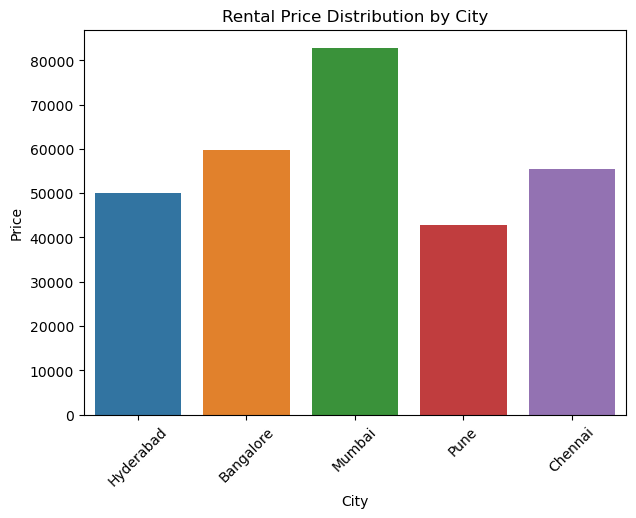

In [51]:
plt.figure(figsize=(7, 5))
sns.barplot(data=df, x='City', y='Price', errorbar=None)
plt.title('Rental Price Distribution by City')
plt.xticks(rotation=45)
plt.show()

##### **Interpretation:**
- The bar chart shows the average rent in each city.
- From the plot, we can observe:
  -  **Mumbai** has the highest average rent.
  -  **Pune** has the lowest average rent.
- This helps to identify which cities are more expensive or affordable for rental housing.

##### 2. BHK vs Average Rent

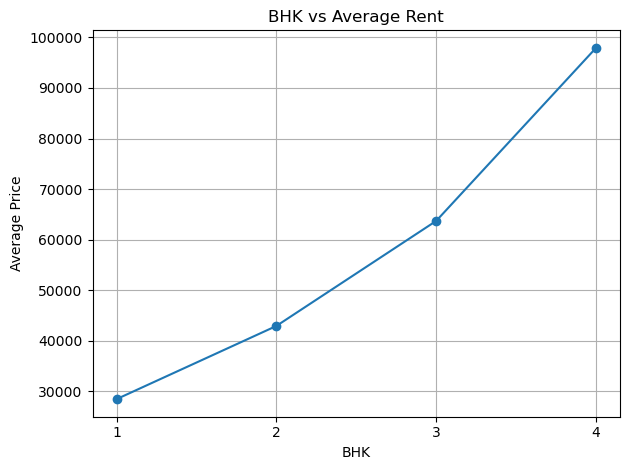

In [53]:
bhk_avg = df.groupby('BHK')['Price'].mean()
bhk_avg.plot(marker='o', linestyle='-', title='BHK vs Average Rent')
plt.xlabel("BHK")
plt.ylabel("Average Price")
plt.grid(True)
plt.xticks(bhk_avg.index, [str(int(b)) for b in bhk_avg.index])
plt.tight_layout()
plt.show()

##### **Interpretation:**
- The line chart shows how average rent increases with the number of BHKs.
- Higher BHKs generally have higher rent.
- Useful for renters and property owners to compare rental costs by BHK size.

##### 3. Top 5 Localities per City Based on Rent

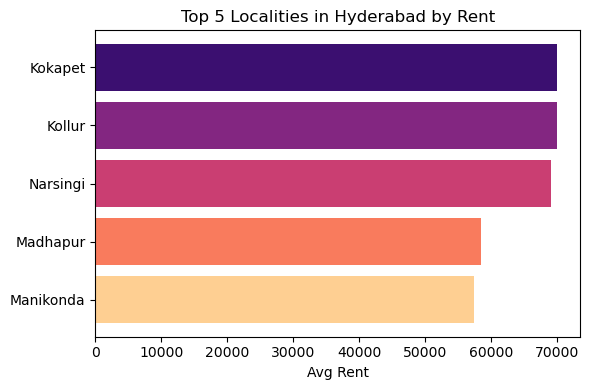

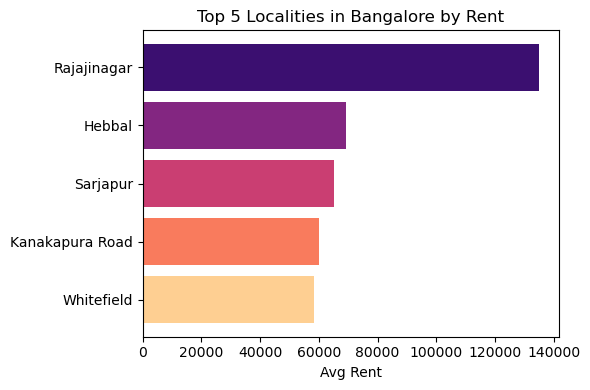

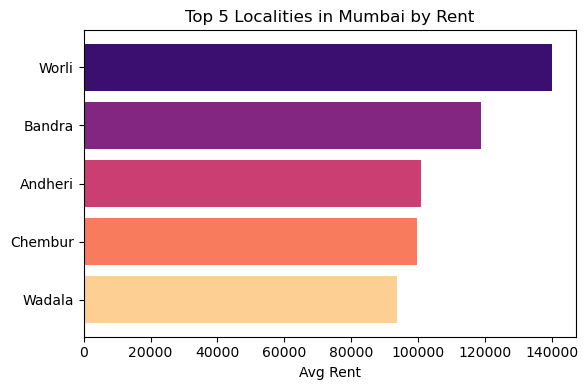

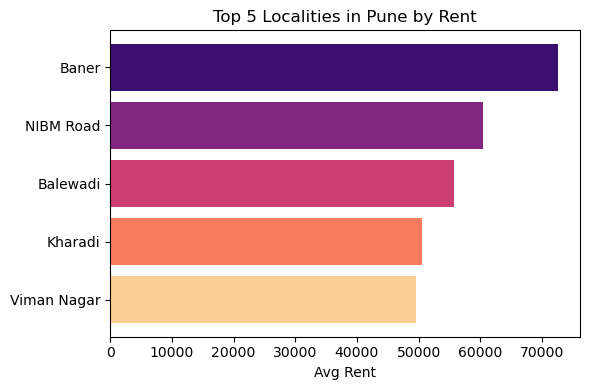

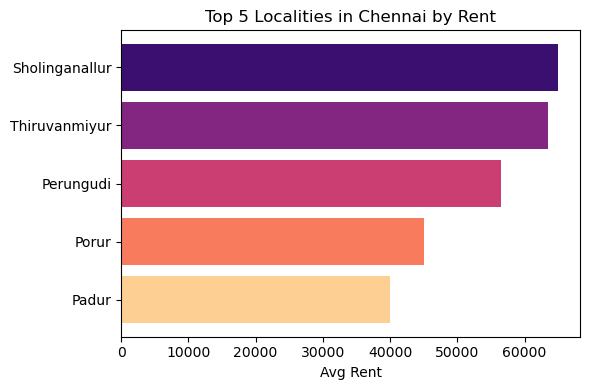

In [64]:
import matplotlib.cm as cm

# Grouping the dataset by City and Location to calculate average rental prices
grouped = df.groupby(['City', 'Location'])['Price'].mean().reset_index()

# Extracting the unique cities from the dataset
cities = df['City'].unique()

# Plotting top 5 localities by average rent for each city
for city in cities:
    top5 = grouped[grouped['City'] == city].sort_values(by='Price', ascending=False).head(5)
    colors = cm.magma(np.linspace(0.2, 0.9, len(top5)))  # Different color for each bar
    
    plt.figure(figsize=(6, 4))
    plt.barh(top5['Location'], top5['Price'], color=colors)
    plt.title(f'Top 5 Localities in {city} by Rent')
    plt.xlabel('Avg Rent')
    plt.gca().invert_yaxis() 
    plt.tight_layout()
    plt.show()

##### **Interpretation:**
- Shows the 5 costliest localities in each city based on average rent.
- Useful for people searching for premium rental properties.
- Horizontal bar charts make rent comparisons between localities easier.
- The topmost bar highlights the highest average rent area in each city.

##### 4. City-wise Furnishing Availability

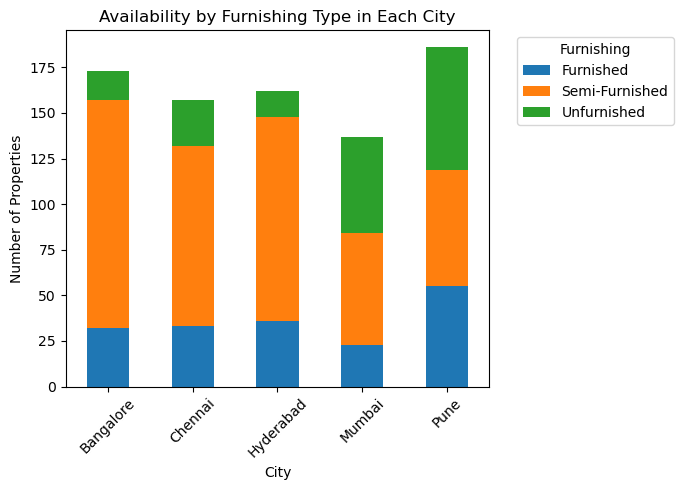

In [66]:
# Group the data by City and Furnishing type and count the number of occurrences in each group
data = df.groupby(['City', 'Furnishing']).size().unstack().fillna(0)

data.plot(kind='bar', stacked=True, figsize=(7, 5))

plt.title('Availability by Furnishing Type in Each City')
plt.xlabel('City')
plt.ylabel('Number of Properties')
plt.xticks(rotation=45)
plt.legend(title='Furnishing', bbox_to_anchor=(1.05, 1), loc='upper left')
# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

##### **Interpretation:**
- This stacked bar chart shows the distribution of rental property availability by furnishing type across different cities. 
- Each bar represents a city, and the segments within each bar represent the number of properties that are Furnished, Semi-Furnished, or Unfurnished. 
- This helps identify furnishing trends in each city. 
- Useful for understanding rental supply patterns and tenant preferences in various urban areas.
- In this chart: 
  - Pune has high Furnished and Unfurnished rental properties.
  - Bangalore has high Semi-Furnished rental properties.

##### 5. Property Type Market Share

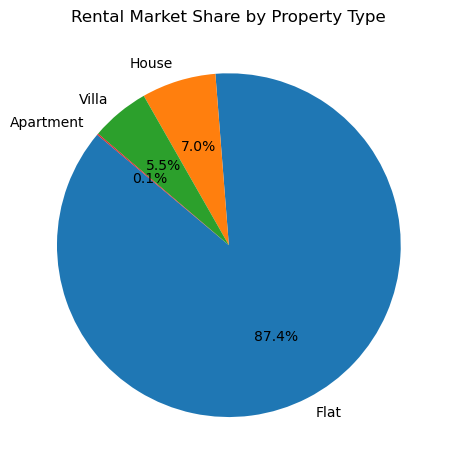

In [67]:
df['Property Type'].value_counts().plot.pie(
    autopct='%1.1f%%', 
    startangle=140, 
    title='Rental Market Share by Property Type'
)
plt.ylabel("")
plt.tight_layout()
plt.show()

##### **Interpretation:**
- Flat property type has the most rental listings.
- Different property types are available for rent.
- Shows what kind of properties are most common in the market.

##### 6. Direction-wise Property Distribution

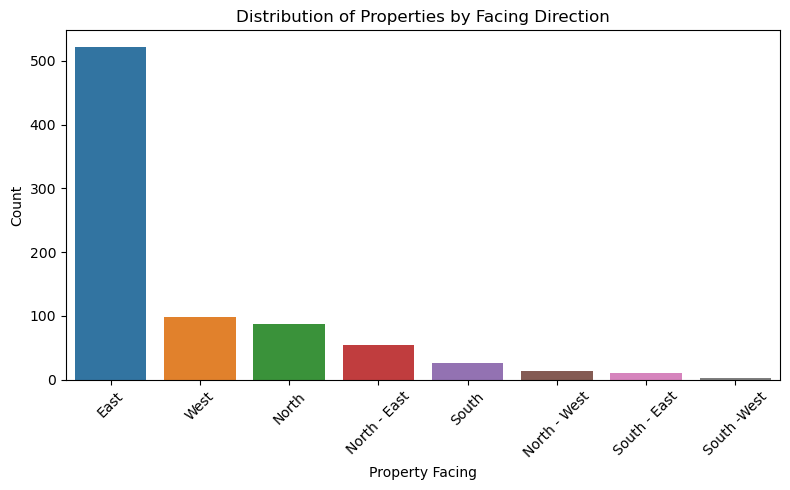

In [68]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Property Facing', order=df['Property Facing'].value_counts().index)
plt.title("Distribution of Properties by Facing Direction")
plt.xlabel("Property Facing")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### **Interpretation:**
- Most properties face the East or North, which are commonly preferred directions.
- Fewer properties face South-West, North-West, etc., indicating lower availability or demand.
- This helps understand user preferences or design patterns in property construction.

##### 7. Price vs Area

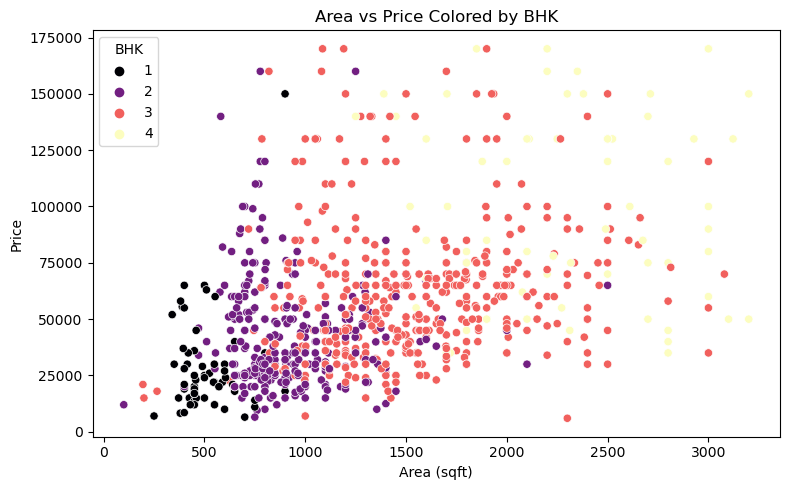

In [69]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='Area (sqft)', y='Price', hue='BHK', palette='magma')
plt.title("Area vs Price Colored by BHK")
plt.xlabel("Area (sqft)")
plt.ylabel("Price")
plt.tight_layout()
plt.show()

##### **Interpretation:**
- This scatter plot shows the relationship between property area and price, with different colors representing BHK counts.
- As expected, larger areas tend to have higher prices. Also, properties with more BHKs generally appear in the higher price and area ranges.

##### 8. BHK Count Distribution Across Cities

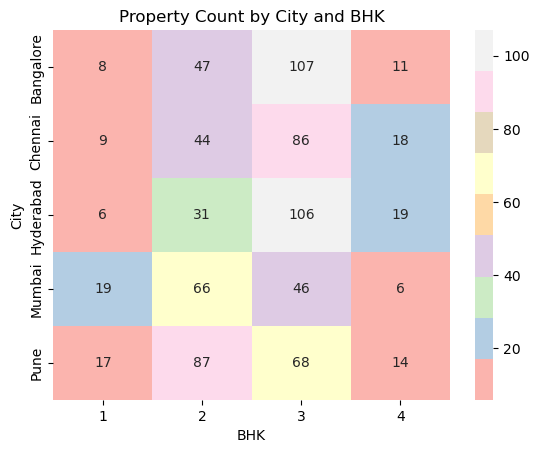

In [70]:
count_data = pd.crosstab(df['City'], df['BHK'])
sns.heatmap(count_data, annot=True, cmap='Pastel1', fmt='d')
plt.title("Property Count by City and BHK")
plt.show()

##### **Interpretation:**
- Each cell shows how many properties of a specific BHK type are available in a city.
  - Rows: Cities
   - Columns: BHK (e.g., 1, 2...)
- Darker cells = higher property count
- This helps identify which BHK types dominate in which cities.

##### 9. City-wise Rent Distribution by Locality

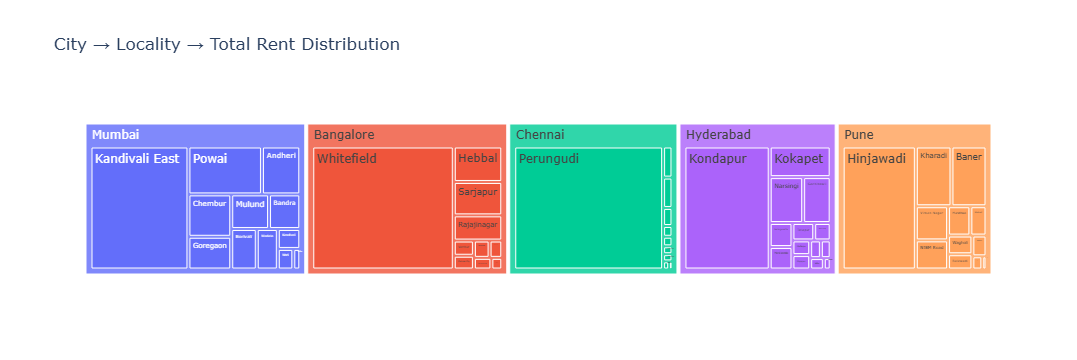

In [71]:
import plotly.express as px

treemap_data = df.groupby(['City', 'Location'])['Price'].sum().reset_index()

fig = px.treemap(
    treemap_data,
    path=['City', 'Location'],
    values='Price',
    title='City → Locality → Total Rent Distribution'
)

fig.show()

##### **Interpretation:**
- Each city is broken down into its top localities based on total rent.
- The size of each block represents the total rental amount for that locality.
- Larger blocks = higher rental contribution from that locality.
- Helps identify high-demand rental hotspots within each city.
- Useful for comparing rent concentration across cities and localities.

##### 10. City-wise Rent by BHK & Furnishing

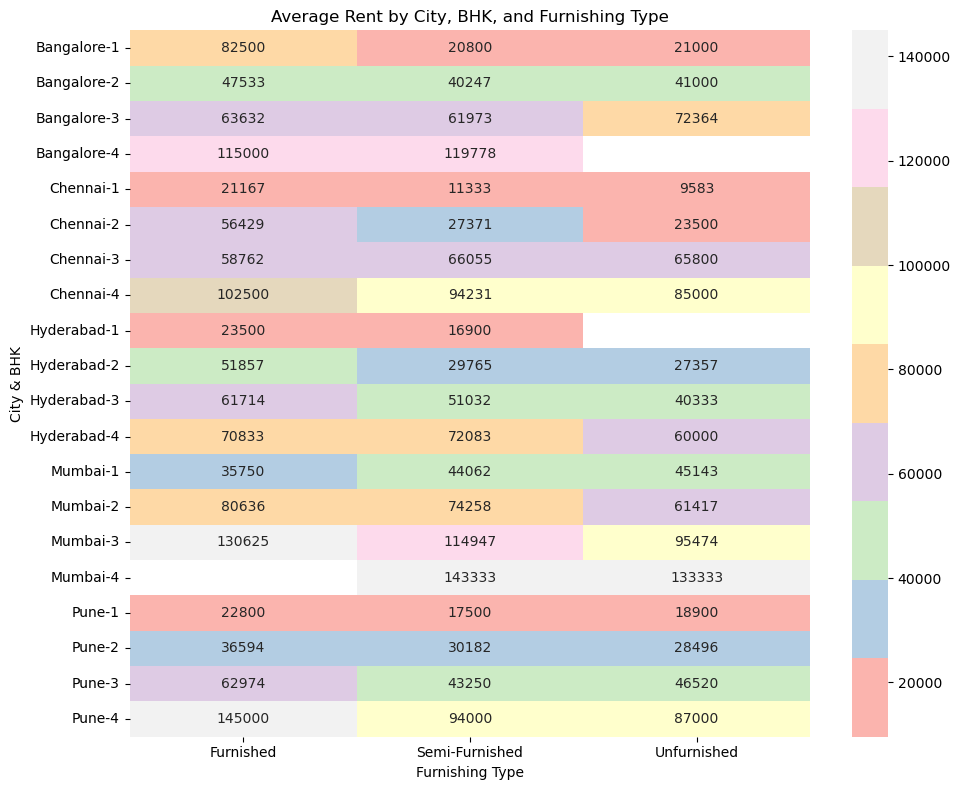

In [72]:
pivot = df.groupby(['City', 'BHK', 'Furnishing'])['Price'].mean().reset_index()
pivot_table = pivot.pivot_table(index=['City', 'BHK'], columns='Furnishing', values='Price')

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, fmt='.0f', cmap='Pastel1')
plt.title('Average Rent by City, BHK, and Furnishing Type')
plt.xlabel('Furnishing Type')
plt.ylabel('City & BHK')
plt.tight_layout()
plt.show()

##### **Interpretation:**
- 3BHK and 4BHK properties consistently show higher rents across all cities.
- Rent increases with the level of furnishing.
- Mumbai has the highest rents, especially for 3BHK and 4BHK furnished flats (up to ₹1.45L+).
- Pune and Hyderabad offer budget-friendly options, especially for 1BHK/2BHK unfurnished units.
- Bangalore and Chennai show mid-range trends, with moderate rent increases based on furnishing.

##### 11. Average Rent Comparison by Property Type

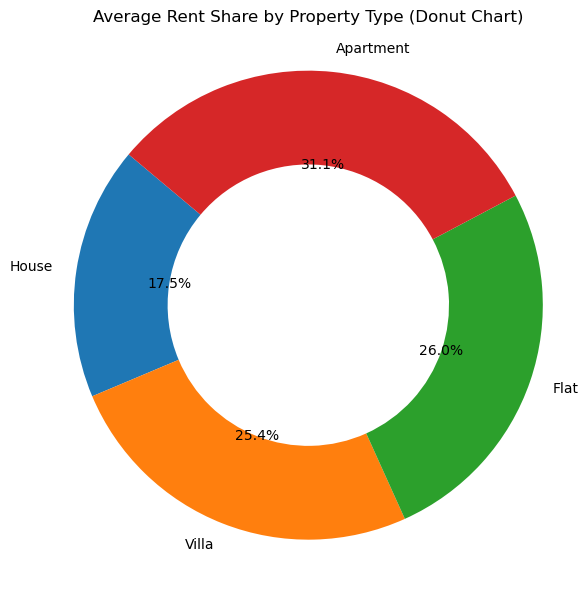

In [74]:
avg_rent = df.groupby('Property Type')['Price'].mean().sort_values()

plt.figure(figsize=(6, 6))
plt.pie(avg_rent.values, labels=avg_rent.index, autopct='%1.1f%%', startangle=140, wedgeprops={'width': 0.4})
plt.title('Average Rent Share by Property Type (Donut Chart)')
plt.axis('equal')
plt.tight_layout()
plt.show()

##### **Interpretation:**
This donut chart displays the proportional contribution of each property type to the overall average rent in the rental market dataset.

- Apartments account for the largest share, contributing 31.1% to the average rent. This suggests they are generally more expensive or have higher average prices than other types.
- Flats follow closely with 26.0%, indicating that they are also priced relatively high in the market.
- Villas contribute 25.4%, implying they are premium properties but not as dominant in average pricing as Apartments or Flats.
- Houses make up the smallest share at 17.5%, indicating they are either less expensive on average or less frequently available at high price points.

#### Conclusion

The objective of this project is to analyze rental data from MagicBricks across 5 major cities, uncovering price trends, city-wise comparisons, property features, and top localities.

##### Data Cleaning Summary:
- Removed duplicate entries and standardized key fields like BHK, Price, and Area for uniformity.
- Handled missing values and converted messy values (e.g., “Lac”, “Cr”) into clean numeric formats.
- Identified and treated outliers in Price, BHK, and Area to reduce skewness and ensure reliable insights.
- Final dataset contains 815 cleaned records with 8 meaningful columns.
  
##### EDA Visual Summary:
##### 1. Univariate Analysis
- City-wise Rental Price Distribution: Mumbai and Bangalore have the highest average rental prices, while Pune and Hyderabad are more affordable.
- Furnishing Type Availability in Each City: Semi-furnished properties dominate across all cities, especially in Bangalore and Pune. Fully furnished units are fewer, especially in Hyderabad.
- Rental Market Share by Property Type: Apartments hold the majority share across all cities, with Independent Houses and Villas being less common.
- Distribution of Property Area: Most properties fall in the 500–1500 sqft range, indicating a preference for mid-sized rental spaces.
- Property Facing Direction Distribution: East and North-facing properties are most common, aligning with vastu preferences in Indian real estate.

##### 2. Bivariate/Multivariate Analysis
- Top 5 Localities by City (Based on Rent): Premium areas like Bandra (Mumbai), Whitefield (Bangalore), and Gachibowli (Hyderabad) have higher average rents, indicating demand concentration in tech and commercial hubs.
- BHK vs Average Rent: Rent increases consistently with BHK count. 3 BHK properties command significantly higher rents, especially in Mumbai and Bangalore.
- City-wise Property Facing Preferences: North and East-facing properties dominate across cities, with variation in availability by city – e.g., more North-facing in Pune, more East-facing in Hyderabad.
- Area vs Price (Correlation Heatmap): There’s a positive correlation between area and price, indicating larger homes generally command higher rent. Slight correlation also seen between BHK and Price.

##### Final Summary:
- Performed end-to-end EDA on web-scraped rental property data from MagicBricks across 5 major Indian cities.
- Applied univariate, bivariate, and multivariate analysis to uncover deep insights.
- Used advanced visualizations like: Heatmaps,Tree maps, Scatter plots and more.
- Revealed city-wise rental dynamics, showing how rent varies across cities and localities.
- Identified key influencing features like: BHK count, Area in sqft, Furnishing type, Property facing direction
- Helped understand which locations have premium rent and what property configurations are most common.
- Provided actionable insights for:
  - Tenants: to compare rents across cities/localities
  - Property owners: to understand market pricing
  - Analysts: to track real estate patterns and anomalies